In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('plotting.mplstyle')
import numpy as np
import pandas as pd
import seaborn as sns
cp=sns.color_palette('Dark2', 20)
from scipy.stats import gaussian_kde

### Make lefthand panel of figure 12

**Warning**: This script assumes that you have cloned the repository hosting data for Galaudage+ 2021 (ApJL 921, L15): https://github.com/shanikagalaudage/bbh_spin


Specifically, it assumes that a link to this repository has been created in the following location:

```bash
../code/input/galaudage-data
```

If you have *not* cloned this repository, do the following (replace brackets with actual filepaths):

```bash
$ cd [...desired location...]
$ git clone git@github.com:shanikagalaudage/bbh_spin.git
$ cd [...gwtc3-spin-studies repository]/code/input/
$ ln -s [...path to bbh_spin] galaudage-data
```

In [3]:
# Read in pickled posterior samples from Galaudage+
posts = pd.read_pickle("../code/input/galaudage-data/posterior_samples/posteriors_1.pkl.bz2") \
    + pd.read_pickle("../code/input/galaudage-data/posterior_samples/posteriors_2.pkl.bz2")
posts_zero = pd.read_pickle("../code/input/galaudage-data/posterior_samples/posteriors_zero_1.pkl.bz2") \
    + pd.read_pickle("../code/input/galaudage-data/posterior_samples/posteriors_zero_2.pkl.bz2")

event_ids = []
ff = open("../code/input/galaudage-data/posterior_samples/event_list.txt","r")
for line in ff.read().splitlines():
    event_ids.append(line)

In [4]:
# dict to hold nested sampling p_spinning and bayes factor values for each event
NestedSampling_dict = {}

for i,event in enumerate(event_ids):
    
    ln_ev = posts_zero[i].ln_evidence.values[0]-posts[i].ln_evidence.values[0]
    
    BF = np.exp(ln_ev)
    p_nonspinning = BF/(1+BF)

    NestedSampling_dict[event] = {'BF':BF, 'p_nonspinning': p_nonspinning}

In [5]:
# dict to hold savage dickey p_spinning values and bayes factors for each event
SD_dict = {}

for j,event in enumerate(event_ids):

    a1s = posts[j].a_1.values
    a2s = posts[j].a_2.values

    magnitude_kde = gaussian_kde([a1s, a2s])
    BF = 4*magnitude_kde([0,0])
    
    p_nonspinning = BF/(1+BF) 
    SD_dict[event] = {'BF':BF[0], 'p_nonspinning': p_nonspinning[0]}

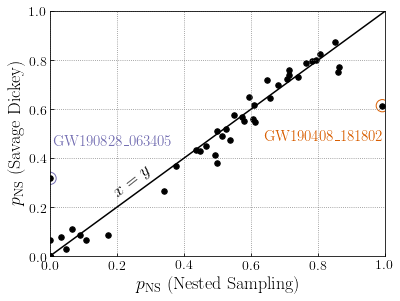

In [28]:
# make figure
fig = plt.figure(figsize=(6,4.5))
plt.style.use('plotting.mplstyle')
NestedSampling_pnonspinning = np.asarray([NestedSampling_dict[event]['p_nonspinning'] for event in NestedSampling_dict])
SD_pnonspinning = np.asarray([SD_dict[event]['p_nonspinning'] for event in SD_dict])
                          
plt.scatter(NestedSampling_pnonspinning, SD_pnonspinning,s=30,c='k')
imax=np.argmax(NestedSampling_pnonspinning)

plt.scatter(NestedSampling_pnonspinning[imax],SD_pnonspinning[imax],s=150, facecolors='none', edgecolors=cp[1])

plt.scatter(NestedSampling_dict['GW190828\_063405']['p_nonspinning'],SD_dict['GW190828\_063405']['p_nonspinning'],
            s=150, facecolors='none', edgecolors=cp[2])

plt.text(0.64,0.47,'GW190408\_181802',c=cp[1],fontsize=15)
plt.text(0.01,0.45,'GW190828\_063405',c=cp[2],fontsize=15)

plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='k')
plt.text(0.18,0.24,'$x=y$',rotation=38,fontsize=18)
plt.xlabel(r'$p_{\mathrm{NS}}$ (Nested Sampling)')
plt.ylabel(r'$p_{\mathrm{NS}}$ (Savage Dickey)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()
fig.savefig("figure_12_left.pdf",bbox_inches='tight')  

### Make righthand panel of figure 12

In [6]:
# Load sampleDict
sampleDict = np.load("../code/input/sampleDict_FAR_1_in_1_yr.pickle", allow_pickle=True)
GW190408_chi1_chi2_posteriors = [sampleDict['S190408an']['a1'], sampleDict['S190408an']['a2']]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


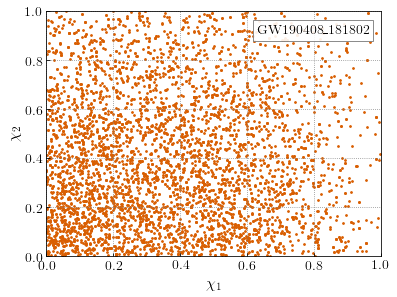

In [7]:
# make figure
idxs = np.random.choice(np.arange(len(GW190408_chi1_chi2_posteriors[0])), replace=False, size=5000)
fig = plt.figure(figsize=(6,4.5))
plt.scatter(GW190408_chi1_chi2_posteriors[0][idxs], GW190408_chi1_chi2_posteriors[1][idxs], s=3, c=cp[1])
plt.xlabel(r'$\chi_1$', fontsize=16)
plt.ylabel(r'$\chi_2$', fontsize=16)
plt.xlim(0,1)
plt.ylim(0,1)
plt.text(0.63,0.905,'GW190408\_181802',c='k',fontsize=14,bbox=dict(boxstyle="square",alpha=0.9, fc="w", ec="0.5"))
plt.show()
fig.savefig("figure_12_right.pdf",bbox_inches='tight') 